In [3]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.measure import centroid
from torchvision import transforms
from torch.utils.data import DataLoader

from myUtils import *

RES = 320

In [4]:
model = torch.load(f'./best_model.pth').eval().cuda()

In [5]:
fp_in = './test_input.mp4'
fp_out = './test_output.mp4'

vidcap = cv2.VideoCapture(fp_in)
frameCount = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
video = torch.empty((frameCount, 3, RES, RES))

success = True
i = 0
while success:
    success, frame = vidcap.read()
    if success:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (RES, RES))
        frame = transforms.ToTensor()(frame)
        video[i] = frame
        i += 1

In [6]:
dataloader = DataLoader(video, batch_size=4)

In [7]:
mask = torch.empty((frameCount, 2, RES, RES), dtype=torch.float64)
filledTo = 0
for batch in dataloader:
    batch = batch.cuda()
    size = batch.shape[0]
    pred = model(batch)

    # add pred to mask
    mask[filledTo:(filledTo + size)] = pred.cpu().detach()
    filledTo += size

del batch, pred, model
torch.cuda.empty_cache()

mask = mask.numpy()

/root/workspace/bar_tracking/venv/lib/python3.9/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


In [8]:
mask.shape

(431, 2, 320, 320)

In [9]:
center = np.empty((frameCount, 2, 2))
idx = 0
for frame in mask:
    center[idx, 0, :] = centroid(frame[0])[::-1]
    center[idx, 1, :] = centroid(frame[1])[::-1]

    idx += 1

center = center/RES
center[:, :, 1] = 1 - center[:, :, 1]

xorigin = mask.sum(axis=2).argmax(axis=2)/RES
yorigin = 1 - mask.sum(axis=3).argmax(axis=2)/RES

center = (np.stack((xorigin, yorigin), axis=2) + center)/2

In [10]:
center.shape

(431, 2, 2)

In [11]:
center

array([[[0.5919898 , 0.3223129 ],
        [0.27746096, 0.70406074]],

       [[0.59214057, 0.32184109],
        [0.2775258 , 0.70410545]],

       [[0.59226958, 0.32182476],
        [0.27739121, 0.70420965]],

       ...,

       [[0.5470889 , 0.32325441],
        [0.2779624 , 0.59531277]],

       [[0.54344601, 0.3225562 ],
        [0.27830698, 0.59553166]],

       [[0.51820244, 0.32783322],
        [0.71821861, 0.57941504]]])

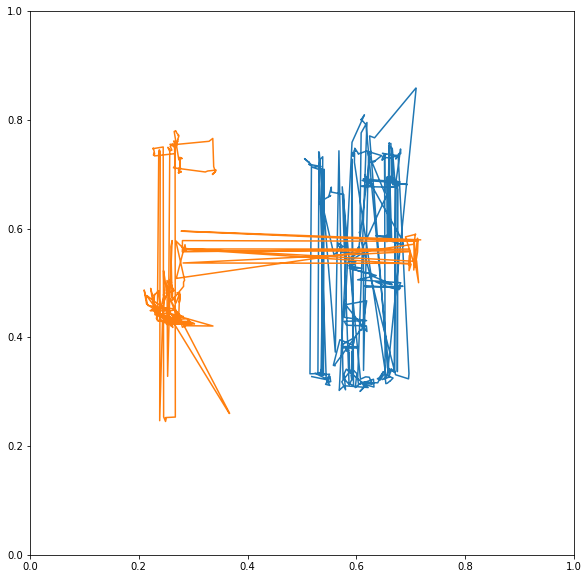

In [12]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.set_aspect('equal')

plt.plot(center[:, :, 0], center[:, :, 1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()